In [0]:
# Importing Libraries

In [0]:
import pandas as pd
import numpy as np
% matplotlib inline
import matplotlib.pyplot as plt

In [0]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [0]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [0]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [4]:
from google.colab import drive
drive.mount('/content/driver/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/driver/


In [6]:
!ls '/content/driver/My Drive/AI/'

Adam_optimization_rp.pdf  important_links_deep_learning.txt
final.csv		  UCI_HAR_Dataset


In [0]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'/content/driver/My Drive/AI/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [0]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'/content/driver/My Drive/AI/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [0]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [0]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    print("\n\nError plot :")
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

In [0]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [0]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [13]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [0]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.normalization import BatchNormalization

In [0]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 16

In [0]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [17]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [18]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


- Defining the Architecture of LSTM

### MODEL 1

In [0]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 16)                1664      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 102       
Total params: 1,766
Trainable params: 1,766
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
# Training the model
history = model.fit(X_train,
                    Y_train,
                    batch_size=batch_size,
                    validation_data=(X_test, Y_test),
                    epochs=epochs)

Instructions for updating:
Use tf.cast instead.
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 28s 4ms/step - loss: 1.5192 - acc: 0.3337 - val_loss: 1.4301 - val_acc: 0.4364
Epoch 2/30
7352/7352 [==============================] - 27s 4ms/step - loss: 1.2675 - acc: 0.4418 - val_loss: 1.2339 - val_acc: 0.5215
Epoch 3/30
7352/7352 [==============================] - 27s 4ms/step - loss: 1.1197 - acc: 0.5209 - val_loss: 1.0894 - val_acc: 0.5222
Epoch 4/30
7352/7352 [==============================] - 27s 4ms/step - loss: 1.0205 - acc: 0.5552 - val_loss: 0.9412 - val_acc: 0.6244
Epoch 5/30
7352/7352 [==============================] - 27s 4ms/step - loss: 0.9244 - acc: 0.6041 - val_loss: 0.9571 - val_acc: 0.5931
Epoch 6/30
7352/7352 [==============================] - 27s 4ms/step - loss: 0.8567 - acc: 0.6160 - val_loss: 0.8376 - val_acc: 0.6176
Epoch 7/30
7352/7352 [==============================] - 28s 4ms/step - loss: 0.7879 - acc: 0.6

2947/2947 [==============================] - 1s 298us/step
score :
[0.6354767117544396, 0.8042076688157448]

confusion matrix : 

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0         0        0                   0   
SITTING                  0      411        74        4                   0   
STANDING                 0      109       412        8                   1   
WALKING                  0        0         0      367                 105   
WALKING_DOWNSTAIRS       0        0         0       25                 346   
WALKING_UPSTAIRS         0        0         1       68                  78   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                            27  
SITTING                            2  
STANDING                           2  
WALKING                           24  
WALKING_DOW

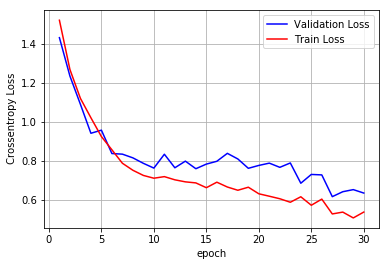

In [0]:
score = model.evaluate(X_test, Y_test)
print("score :")
print(score)

# Confusion Matrix
print("\nconfusion matrix : \n")
print(confusion_matrix(Y_test, model.predict(X_test)))

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel(' Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))


vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

### MODEL 2

In [0]:
# Initiliazing the sequential model
n_hidden = 64
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
# Training the model
history = model.fit(X_train,
                    Y_train,
                    batch_size=batch_size,
                    validation_data=(X_test, Y_test),
                    epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 36s 5ms/step - loss: 1.2550 - acc: 0.4520 - val_loss: 1.1046 - val_acc: 0.5314
Epoch 2/30
7352/7352 [==============================] - 35s 5ms/step - loss: 0.9681 - acc: 0.5822 - val_loss: 0.8536 - val_acc: 0.6230
Epoch 3/30
7352/7352 [==============================] - 35s 5ms/step - loss: 0.7252 - acc: 0.6866 - val_loss: 1.1604 - val_acc: 0.6091
Epoch 4/30
7352/7352 [==============================] - 35s 5ms/step - loss: 0.5630 - acc: 0.8005 - val_loss: 0.5614 - val_acc: 0.8134
Epoch 5/30
7352/7352 [==============================] - 36s 5ms/step - loss: 0.4311 - acc: 0.8645 - val_loss: 0.4468 - val_acc: 0.8524
Epoch 6/30
7352/7352 [==============================] - 35s 5ms/step - loss: 0.3349 - acc: 0.8904 - val_loss: 0.4545 - val_acc: 0.8605
Epoch 7/30
7352/7352 [==============================] - 35s 5ms/step - loss: 0.2725 - acc: 0.9120 - val_loss: 0.4657 - val_acc: 0.8453
Epoch 8

2947/2947 [==============================] - 2s 521us/step
score :
[0.45613155783282117, 0.8961655921275874]

confusion matrix : 

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0        27        0                   0   
SITTING                  0      441        47        0                   1   
STANDING                 0      164       368        0                   0   
WALKING                  0        3         0      439                  35   
WALKING_DOWNSTAIRS       0        0         0        1                 416   
WALKING_UPSTAIRS         0        1         1        1                   1   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            2  
STANDING                           0  
WALKING                           19  
WALKING_DO

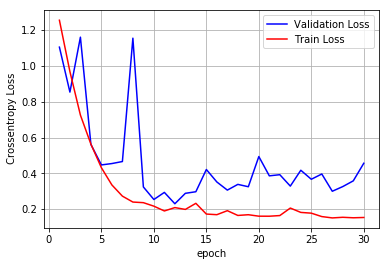

In [0]:
score = model.evaluate(X_test, Y_test)
print("score :")
print(score)

# Confusion Matrix
print("\nconfusion matrix : \n")
print(confusion_matrix(Y_test, model.predict(X_test)))

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel(' Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))


vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

### MODEL 3

In [0]:
# Initiliazing the sequential model
n_hidden = 64
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.75))
model.add(LSTM(32))
model.add(Dropout(0.75))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 64)           18944     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 64)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 31,558
Trainable params: 31,558
Non-trainable params: 0
_________________

In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
# Training the model
history = model.fit(X_train,
                    Y_train,
                    batch_size=batch_size,
                    validation_data=(X_test, Y_test),
                    epochs=epochs)

Instructions for updating:
Use tf.cast instead.
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 71s 10ms/step - loss: 1.3424 - acc: 0.4256 - val_loss: 1.0697 - val_acc: 0.5711
Epoch 2/30
7352/7352 [==============================] - 68s 9ms/step - loss: 1.0095 - acc: 0.5661 - val_loss: 0.8805 - val_acc: 0.5721
Epoch 3/30
7352/7352 [==============================] - 68s 9ms/step - loss: 0.8845 - acc: 0.5982 - val_loss: 0.8010 - val_acc: 0.6325
Epoch 4/30
7352/7352 [==============================] - 69s 9ms/step - loss: 0.8813 - acc: 0.6110 - val_loss: 0.8202 - val_acc: 0.6200
Epoch 5/30
7352/7352 [==============================] - 69s 9ms/step - loss: 0.7985 - acc: 0.6194 - val_loss: 0.7927 - val_acc: 0.6183
Epoch 6/30
7352/7352 [==============================] - 68s 9ms/step - loss: 0.7973 - acc: 0.6347 - val_loss: 0.7663 - val_acc: 0.6200
Epoch 7/30
7352/7352 [==============================] - 67s 9ms/step - loss: 0.7916 - acc: 0.

2947/2947 [==============================] - 3s 939us/step
score :
[0.3533073152155683, 0.9053274516457415]

confusion matrix : 

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 509        1         0        0                   0   
SITTING                  0      404        87        0                   0   
STANDING                 0       97       434        1                   0   
WALKING                  0        0         0      478                   0   
WALKING_DOWNSTAIRS       0        0         0        0                 392   
WALKING_UPSTAIRS         0        2         0       15                   3   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                            27  
SITTING                            0  
STANDING                           0  
WALKING                           18  
WALKING_DOW

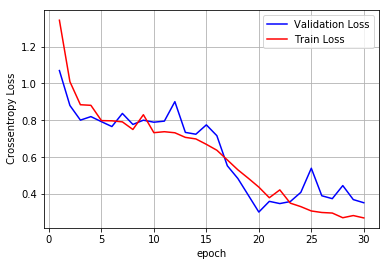

In [0]:
score = model.evaluate(X_test, Y_test)
print("score :")
print(score)

# Confusion Matrix
print("\nconfusion matrix : \n")
print(confusion_matrix(Y_test, model.predict(X_test)))

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel(' Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))


vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

### MODEL 4

In [0]:
# Initiliazing the sequential model
n_hidden = 64
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.7))
model.add(LSTM(16))
model.add(Dropout(0.7))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 128, 64)           18944     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128, 64)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 16)                5184      
_________________________________________________________________
dropout_11 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 102       
Total params: 24,230
Trainable params: 24,230
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
# Training the model
history = model.fit(X_train,
                    Y_train,
                    batch_size=batch_size,
                    validation_data=(X_test, Y_test),
                    epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 70s 9ms/step - loss: 1.4278 - acc: 0.4264 - val_loss: 1.6103 - val_acc: 0.3098
Epoch 2/30
7352/7352 [==============================] - 66s 9ms/step - loss: 1.1181 - acc: 0.4936 - val_loss: 0.9450 - val_acc: 0.5059
Epoch 3/30
7352/7352 [==============================] - 65s 9ms/step - loss: 1.1362 - acc: 0.4736 - val_loss: 0.8305 - val_acc: 0.5769
Epoch 4/30
7352/7352 [==============================] - 65s 9ms/step - loss: 0.9416 - acc: 0.5208 - val_loss: 0.7901 - val_acc: 0.5931
Epoch 5/30
7352/7352 [==============================] - 65s 9ms/step - loss: 0.9101 - acc: 0.5452 - val_loss: 0.7962 - val_acc: 0.5877
Epoch 6/30
7352/7352 [==============================] - 66s 9ms/step - loss: 0.8718 - acc: 0.5521 - val_loss: 0.8544 - val_acc: 0.5545
Epoch 7/30
7352/7352 [==============================] - 65s 9ms/step - loss: 0.8729 - acc: 0.5597 - val_loss: 0.7735 - val_acc: 0.6240
Epoch 8

2947/2947 [==============================] - 3s 878us/step
score :
[0.5620518186318296, 0.7570410587037666]

confusion matrix : 

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0        27        0                   0   
SITTING                  0      372       118        0                   1   
STANDING                 0       86       445        1                   0   
WALKING                  0        0         0      495                   1   
WALKING_DOWNSTAIRS       0        0         0       13                 407   
WALKING_UPSTAIRS         0        4         6      451                   8   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            0  
STANDING                           0  
WALKING                            0  
WALKING_DOW

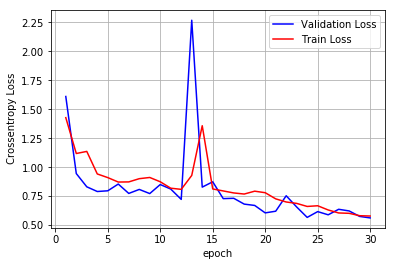

In [0]:
score = model.evaluate(X_test, Y_test)
print("score :")
print(score)

# Confusion Matrix
print("\nconfusion matrix : \n")
print(confusion_matrix(Y_test, model.predict(X_test)))

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel(' Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))


vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

### MODEL 5

In [0]:
# Initiliazing the sequential model
n_hidden = 64
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 128, 64)           18944     
_________________________________________________________________
batch_normalization_5 (Batch (None, 128, 64)           256       
_________________________________________________________________
dropout_16 (Dropout)         (None, 128, 64)           0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_17 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 198       
Total params: 31,814
Trainable params: 31,686
Non-trainable params: 128
_________________________________________________________________


In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
# Training the model
history = model.fit(X_train,
                    Y_train,
                    batch_size=batch_size,
                    validation_data=(X_test, Y_test),
                    epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 76s 10ms/step - loss: 1.0221 - acc: 0.6075 - val_loss: 0.9786 - val_acc: 0.5368
Epoch 2/30
7352/7352 [==============================] - 72s 10ms/step - loss: 0.6885 - acc: 0.7349 - val_loss: 0.6770 - val_acc: 0.6610
Epoch 3/30
7352/7352 [==============================] - 73s 10ms/step - loss: 0.4560 - acc: 0.8697 - val_loss: 0.3667 - val_acc: 0.8660
Epoch 4/30
7352/7352 [==============================] - 73s 10ms/step - loss: 0.3274 - acc: 0.9056 - val_loss: 0.3366 - val_acc: 0.8846
Epoch 5/30
7352/7352 [==============================] - 72s 10ms/step - loss: 0.2615 - acc: 0.9266 - val_loss: 0.2491 - val_acc: 0.9192
Epoch 6/30
7352/7352 [==============================] - 72s 10ms/step - loss: 0.2303 - acc: 0.9276 - val_loss: 0.2935 - val_acc: 0.9111
Epoch 7/30
7352/7352 [==============================] - 73s 10ms/step - loss: 0.2123 - acc: 0.9328 - val_loss: 0.2739 - val_acc: 0.9121


2947/2947 [==============================] - 3s 1ms/step
score :
[0.27789034991822054, 0.9151679674244995]

confusion matrix : 

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 537        0         0        0                   0   
SITTING                  6      422        62        0                   0   
STANDING                 0      134       398        0                   0   
WALKING                  0        0         0      490                   6   
WALKING_DOWNSTAIRS       0        0         0        0                 417   
WALKING_UPSTAIRS         1       11         1        6                  19   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            1  
STANDING                           0  
WALKING                            0  
WALKING_DOWN

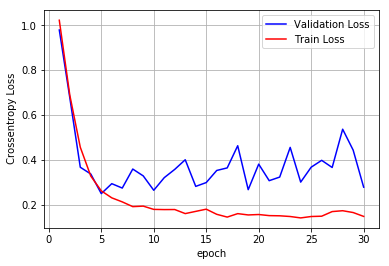

In [0]:
score = model.evaluate(X_test, Y_test)
print("score :")
print(score)

# Confusion Matrix
print("\nconfusion matrix : \n")
print(confusion_matrix(Y_test, model.predict(X_test)))

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel(' Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))


vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [0]:
from prettytable import PrettyTable

In [28]:
x = PrettyTable()
x.field_names = ["Model","Architecture","Dropout", "accuracy (%)","loss"]
x.add_row(["1","16-D-FC", 0.5, 80.42, 0.635])
x.add_row(["2","64-D-FC",0.5, 89.61, 0.456])
x.add_row(["3","64-D-32-D-FC", 0.75, 90.53, 0.353])
x.add_row(["4","64-D-16-D-FC",0.7, 75.70, 0.562])
x.add_row(["5","64-BN-D-32-D-FC",0.5, 91.52, 0.277])
print('Model Comparison')
print(x)

Model Comparison
+-------+-----------------+---------+--------------+-------+
| Model |   Architecture  | Dropout | accuracy (%) |  loss |
+-------+-----------------+---------+--------------+-------+
|   1   |     16-D-FC     |   0.5   |    80.42     | 0.635 |
|   2   |     64-D-FC     |   0.5   |    89.61     | 0.456 |
|   3   |   64-D-32-D-FC  |   0.75  |    90.53     | 0.353 |
|   4   |   64-D-16-D-FC  |   0.7   |     75.7     | 0.562 |
|   5   | 64-BN-D-32-D-FC |   0.5   |    91.52     | 0.277 |
+-------+-----------------+---------+--------------+-------+


- With a 2 layer architecture we got 91.52% accuracy and a loss of 0.277
- deep learning allow us to built sensible models without expert knowledge

### Step Followed :
- Obtain train and test data.
- Perform data cleaning(checking duplicates and nan values)
- Perform EDA on data.
- Plot plots histogram etc also 2D plots help of T-sne.
- Define utility functions
- Train linear models with expert features.
- Compare performance of linear models
- Train various deep learning LSTM models and compare them.